## Classifying MNIST with Le-Net (MyGrad and MyNN)

In this notebook, we will be training a convolutional neural network (using the Le-Net design described in [this paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)) to classify hand-written digits. We will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which contains labeled images of hand-written digits from 0 to 9. The MNIST dataset has a training set of 60,000 images and a test set of 10,000 images. 

When working through the tendril dataset, you worked through creating a 2 layer dense network with and without MyNN so you should have a feel for how to work with it by now.

``` bash
$ git clone https://github.com/davidmascharka/MyNN
$ cd MyNN
$ python setup.py develop
```

You should also have downloaded the [DataSets repo](https://github.com/CogWorksBWSI/DataSets), installed it, and set it up using `python setup.py develop` within that directory. This provides you with the mnist dataset, and a function for loading it, which we will use below.

We will be replicating the famous "LeNet" CNN architecture, which was one of the first convolutional neural network designs. We will explain the architecture and operations used in convolutional neural nets throughout this notebook. 

In [2]:
import numpy as np
import mygrad as mg
from mygrad import Tensor

from noggin import create_plot
import matplotlib.pyplot as plt

%matplotlib notebook

### MNIST Data Loading and preprocessing

First, we will load in our data using handy functions from the datasets repo. If you haven't already, download the data by calling `download_mnist()`


In [3]:
from datasets import load_mnist, download_mnist
download_mnist()

`datasets module: datasets will be loaded from '/home/fish/datasets'
File already exists:
	/home/fish/datasets/mnist.npz


In [4]:
# loading in the dataset with train/test data/labels
x_train, y_train, x_test, y_test = load_mnist()

mnist loaded


What is the shape and data-types of these arrays? What is the shape of each individual image? How many color-channels does each number have.



Let's plot some examples from the MNIST dataset below


<IPython.core.display.Javascript object>


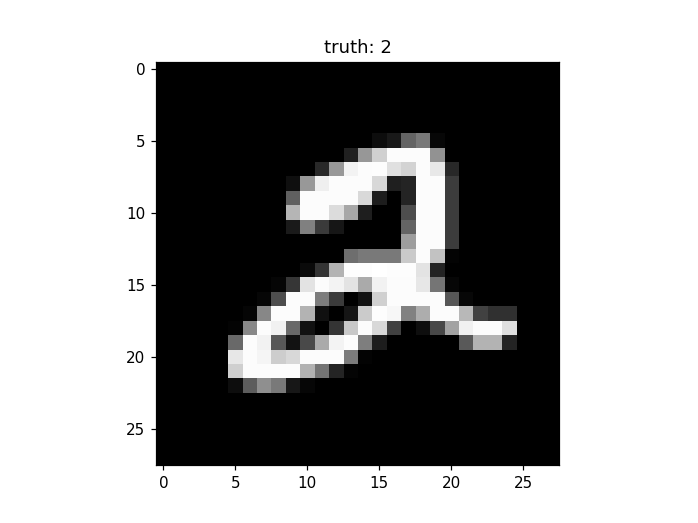

In [5]:
img_id = 5

fig, ax = plt.subplots()
ax.imshow(x_train[img_id, 0], cmap="gray")
ax.set_title(f"truth: {y_train[img_id]}");

We will want to turn these 28x28 images into 32x32 images, for the sake of compatibility with the convolutions that we want to do. We can simply pad two rows/columns of zeros to all sides of the images


In [6]:
# zero-pad the images
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")

The original images stored unsigned 8bit integers for their pixel values. We need to convert these to floating-point values. Let's convert the images (not the labels) 32-bit floats:


In [7]:
x_train = x_train.astype(np.float32) / 255
x_test = x_train.astype(np.float32) / 255

Finally, we need to normalize these images. With cifar-10, we shifted the images by the mean and divided by the standard deviation. Here, let's be a little laze and simply normalize the images so that their values lie on $[0, 1]$


In [8]:
gain = {'gain': np.sqrt(2)}

In [9]:
# STUDENT CODE HERE

## The "LeNet" Architecture


In the convnet to classify MNIST images, we will construct a CNN with two convolutional layers each structured as: 

```
conv layer --> relu --> pooling layer
```

, followed by two dense layers with a relu between them. Thus our network is:

```
CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FLATTEN -> DENSE -> RELU -> DENSE -> SOFTMAX
```



### Layer Details

CONV-1: 20 filters, 5x5, stride-1

POOL-1: 2x2, stride-2

CONV-2: 10 filters, 5x5, stride-1

POOL-2: 2x2, stride-2

DENSE-3: size-20

DENSE-4: size-???

### Activations

We will be using the "Glorot Uniform" initialization scheme for all of our layers' weights (the biases will be 0, which is the default). If you would like to read more about how Xavier Glorot explains the rationalization behind these weight initializations, look here for [his paper written with Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

This initialization scheme takes an additional "gain parameter", which will be $\sqrt{2}$ for us. Use the following syntax for specifying this gain:

```python
from mynn.initializers.glorot_uniform import glorot_uniform

gain = {'gain': np.sqrt(2)}

# E.g. initializing a dense layer with glorot-uniform initialization
# and a gain of root-2
dense(250, 20, 
      weight_initializer=glorot_uniform, 
      weight_kwargs=gain)
```

In [10]:
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout
from mynn.activations.relu import relu
from mynn.initializers.glorot_uniform import glorot_uniform
from mygrad.nnet.layers import max_pool
from mygrad.nnet.losses import softmax_crossentropy

In [11]:
# Define your `Model`-MyNN class for the architecture prescribed above.

class Model:
    def __init__(self, isize, class_num, flat_size):
        # initialize the three dense layers with the appropriate input/output dimenions
        # use ``weight_initializer=he_normal``
        
        self.conv1 = conv(isize, 20, [5, 5], weight_initializer=glorot_uniform, weight_kwargs=gain)
        self.conv2 = conv(20, 10, [5, 5], weight_initializer=glorot_uniform, weight_kwargs=gain)
        self.dense3 = dense(flat_size, 20, weight_initializer=glorot_uniform, weight_kwargs=gain)
        self.dense4 = dense(20, class_num, weight_initializer=glorot_uniform, weight_kwargs=gain)
        
        
    def __call__(self, x):
        ''' Forward data through the network.
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(N, D)
            The data to forward through the network.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 1)
            The model outputs.
        '''
        N = x.shape[0]
        
        first = max_pool(relu(self.conv1(x)), (2, 2), 2)
        
        second = max_pool(relu(self.conv2(first)), (2, 2), 2).reshape(N, -1)
        third = relu(self.dense3(second))
        return self.dense4(third)
        
        
        
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.conv1.parameters + self.conv2.parameters + self.dense3.parameters + self.dense4.parameters

In [12]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

Initialize the SGD-optimizer. We will be adding a new feature to our update method, known as ["momentum"](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum). The following is a sensible configuration for the optimizer:

```python
SGD(<your model parameters>, learning_rate=0.01, momentum=0.9, weight_decay=5e-04)
```

In [13]:
# Import SGD and initialize it as described above
# Also initialize your model
# STUDENT CODE HERE
from mynn.optimizers.sgd import SGD
model = Model(1, 10, 250)

<IPython.core.display.Javascript object>


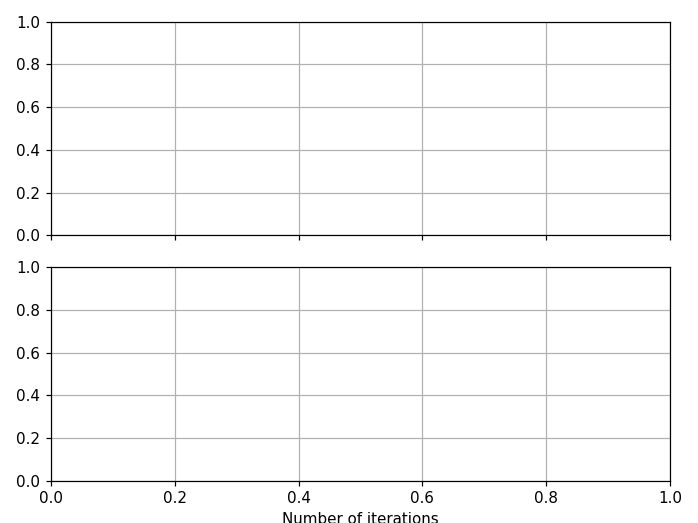

In [14]:
plotter, fig, ax = create_plot(["loss", "accuracy"])

optim = SGD(model.parameters, learning_rate=0.1, weight_decay=.0001) 

Using a batch-size of 100, train your convolutional neural network. Try running through 3 epochs of your data - this may take a while. Plot training-loss and training accuracy, via noggin, for each batch. After each epoch, measure the *test* accuracy of your model on the entire test set - do not perform backprop for this stage. You should find that your network gets excellent performance.

Reference the cifar-10 (solution) notebook for guidance on this.

In [ ]:
from mygrad.nnet.losses import softmax_crossentropy

# Set `batch_size = 100`: the number of predictions that we will make in each training step
batch_size = 100

# We will train for 10 epochs; you can change this if you'd like
for epoch_cnt in range(3):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    print(epoch_cnt)
    
    
    for batch_cnt in range(0, len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        prediction = model(batch)
        
        #print(batch.shape)
        
        #print(prediction.shape)
        

        # compute the true (a.k.a desired) values for this batch: 
        truth = y_train[batch_indices]

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_crossentropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()
        
        acc = accuracy(prediction, truth)
 

        # execute gradient descent by calling step() of optim
        optim.step()
        loss.null_gradients()
    
       
        plotter.set_test_batch({"accuracy" : acc, "loss" : loss.item()}, batch_size=batch_size)
        
    
    plotter.set_test_epoch()

0


Referencing the matplotlib code at the top of the notebook, visualize some images and check your model's predictions for them.

Also, use your model and the truth data to find images that the model *fails* to get right - plot some of these fail cases.

In [ ]:
test_idxs = np.arange(len(x_test))
prediction = model(x_test)
